# 🔁 Forecast All Features Including Ratios for Last Week of 2019

This notebook forecasts all core input features **including** `solar_load_ratio` and `wind_load_ratio`
as standalone time series. It assumes **no data is available** for the last week of 2019 and simulates
the forecast using historical data up to Dec 24, 2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from pathlib import Path

# Load the dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Compute ratio features
df['solar_load_ratio'] = df['DE_solar_generation_actual'] / df['DE_load_actual_entsoe_transparency']
df['wind_load_ratio'] = df['DE_wind_generation_actual'] / df['DE_load_actual_entsoe_transparency']

## 🎯 Step 1: Forecast all input and ratio features for Dec 25–31, 2019

🔮 Forecasting: DE_solar_generation_actual


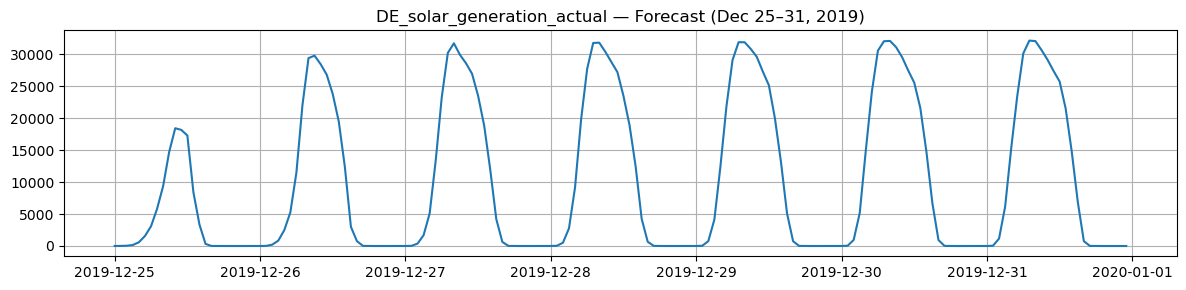

🔮 Forecasting: DE_wind_generation_actual


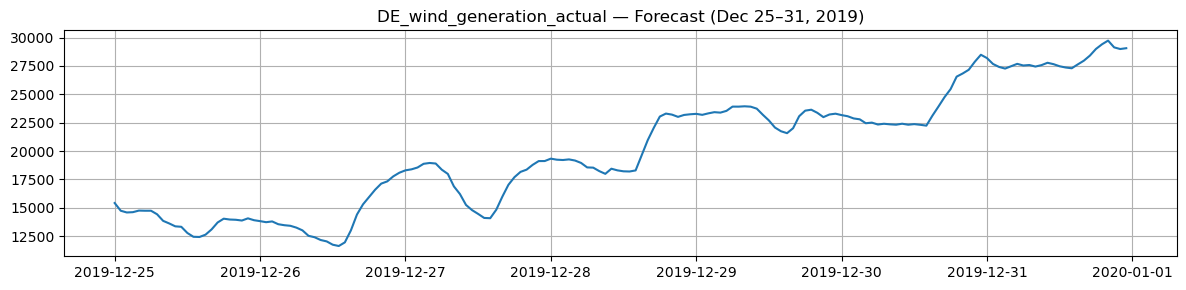

🔮 Forecasting: DE_load_actual_entsoe_transparency


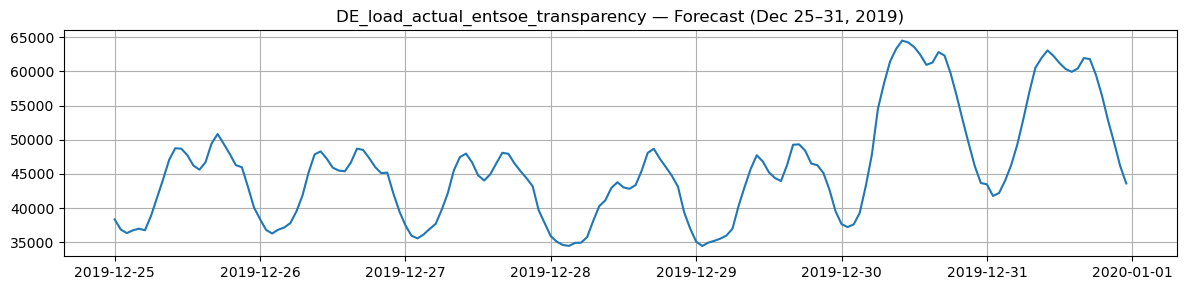

🔮 Forecasting: Gas_Price


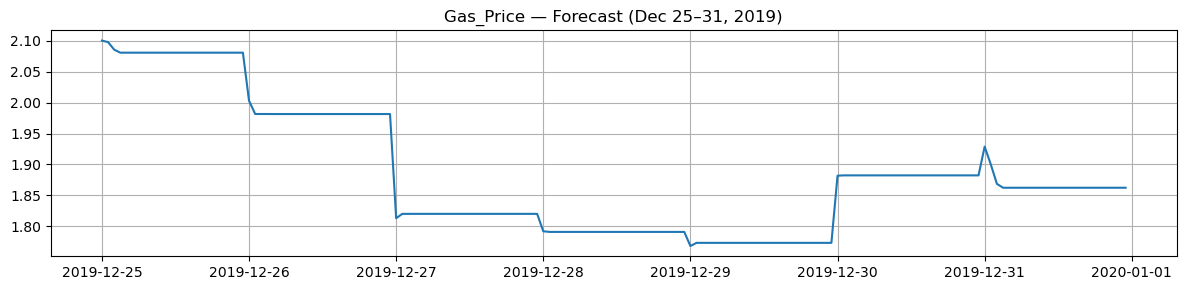

🔮 Forecasting: Oil_Price


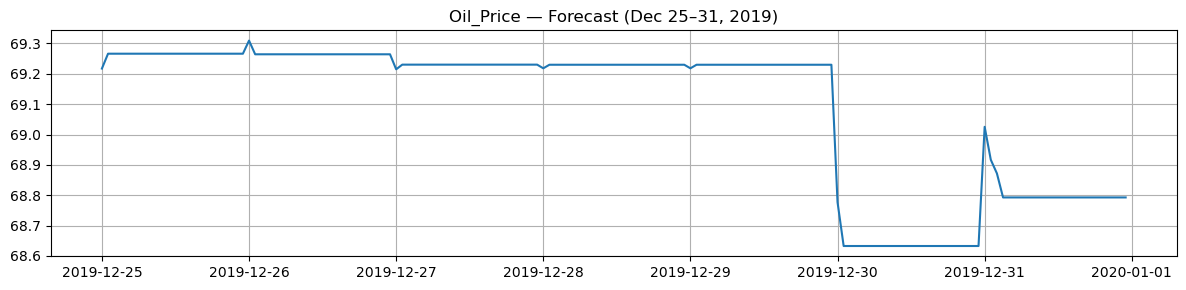

🔮 Forecasting: DE_radiation_direct_horizontal


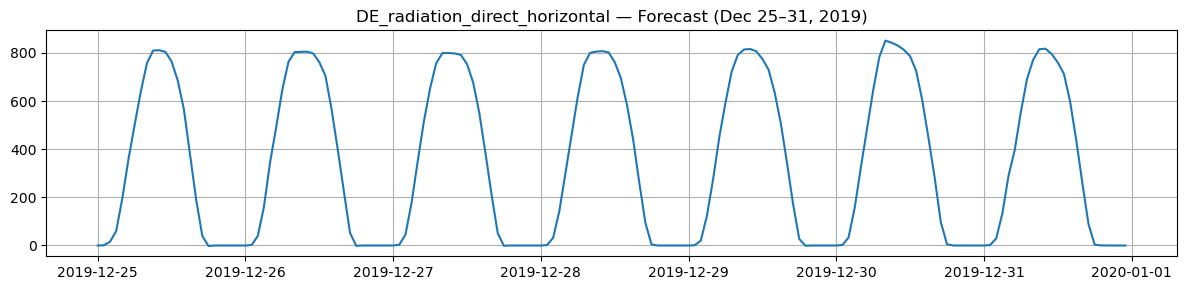

🔮 Forecasting: DE_radiation_diffuse_horizontal


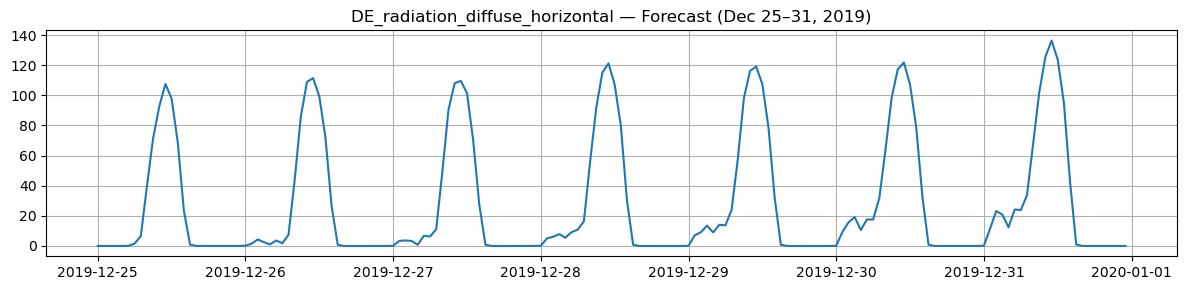

🔮 Forecasting: DE_temperature


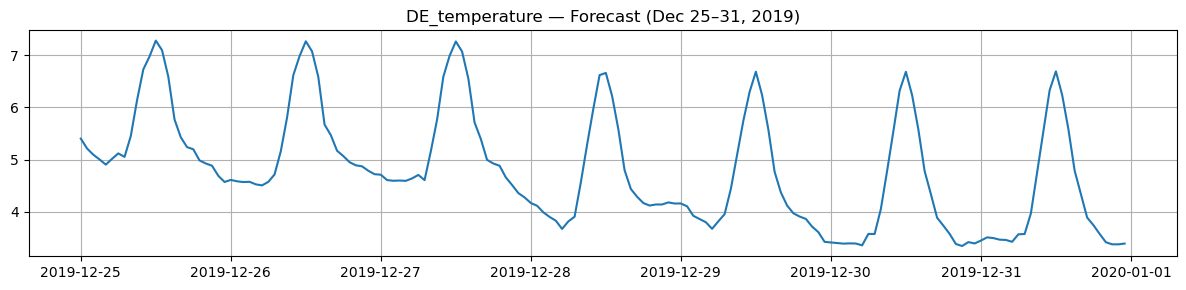

🔮 Forecasting: solar_load_ratio


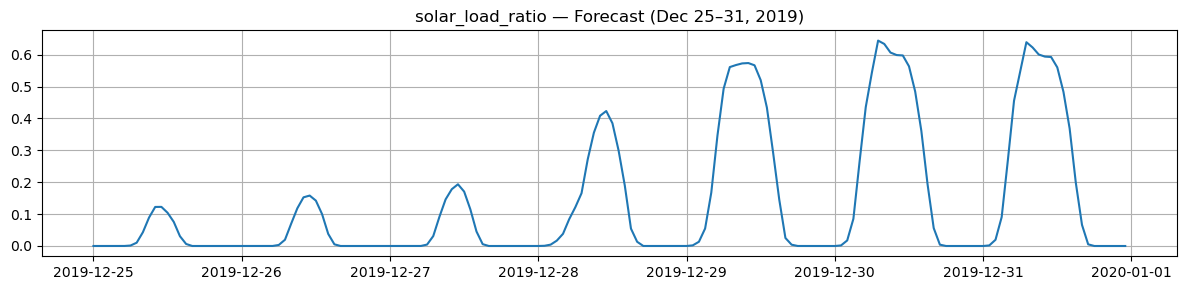

🔮 Forecasting: wind_load_ratio


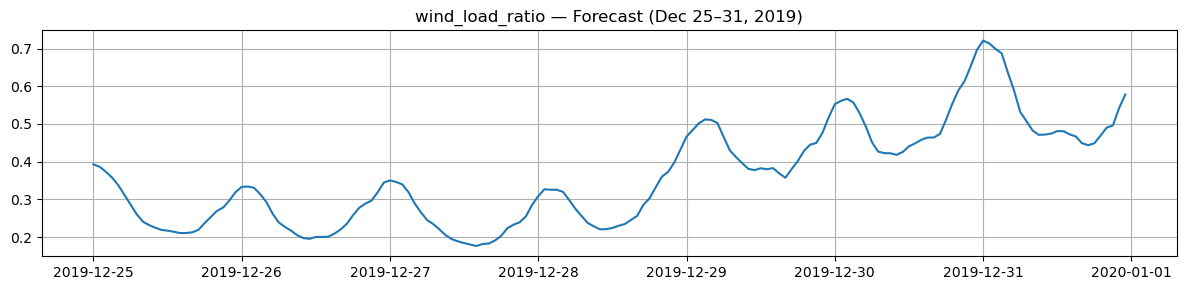

✅ Saved forecasted features (including ratios) to processed folder.


In [2]:
# Full feature list
features_to_forecast = [
    'DE_solar_generation_actual', 'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price', 'Oil_Price',
    'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
    'DE_temperature',
    'solar_load_ratio', 'wind_load_ratio'
]

# Set forecast window
forecast_start = pd.Timestamp('2019-12-25 00:00:00')
forecast_end = pd.Timestamp('2019-12-31 23:00:00')
forecast_steps = int((forecast_end - forecast_start).total_seconds() // 3600 + 1)

predicted_features = {}

for feature in features_to_forecast:
    print(f'🔮 Forecasting: {feature}')
    
    data = df[[feature]].copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month

    for lag in [1, 24, 168]:
        data[f'lag_{lag}'] = data[feature].shift(lag)
    data.dropna(inplace=True)

    X = data[[f'lag_{l}' for l in [1, 24, 168]] + ['hour', 'dayofweek', 'month']]
    y = data[feature]

    model = XGBRegressor(n_estimators=100)
    model.fit(X, y)

    # Start from 168h before forecast
    current = df.loc[forecast_start - pd.Timedelta(hours=168):forecast_start - pd.Timedelta(hours=1), feature].copy()
    predictions = []

    for i in range(forecast_steps):
        t = forecast_start + pd.Timedelta(hours=i)
        row = {
            'lag_1': current.iloc[-1],
            'lag_24': current.iloc[-24],
            'lag_168': current.iloc[-168],
            'hour': t.hour,
            'dayofweek': t.dayofweek,
            'month': t.month
        }
        x_input = pd.DataFrame([row])
        y_pred = model.predict(x_input)[0]
        predictions.append((t, y_pred))
        current.loc[t] = y_pred

    predicted_df = pd.DataFrame(predictions, columns=['utc_timestamp', feature]).set_index('utc_timestamp')
    predicted_features[feature] = predicted_df

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(predicted_df.index, predicted_df[feature], label='Forecasted')
    plt.title(f'{feature} — Forecast (Dec 25–31, 2019)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Combine and save
combined = pd.concat(predicted_features.values(), axis=1)
combined.to_csv('../data/processed/forecasted_all_features_with_ratios_last_week_2019.csv')
print('✅ Saved forecasted features (including ratios) to processed folder.')

📊 Feature Forecast Evaluation for Dec 25–31, 2019

DE_solar_generation_actual → MAE: 7998.81, RMSE: 12856.86


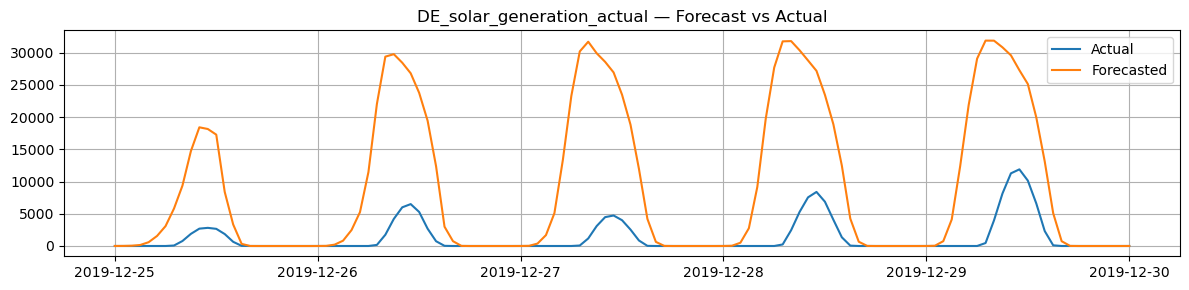

DE_wind_generation_actual → MAE: 8617.67, RMSE: 9812.16


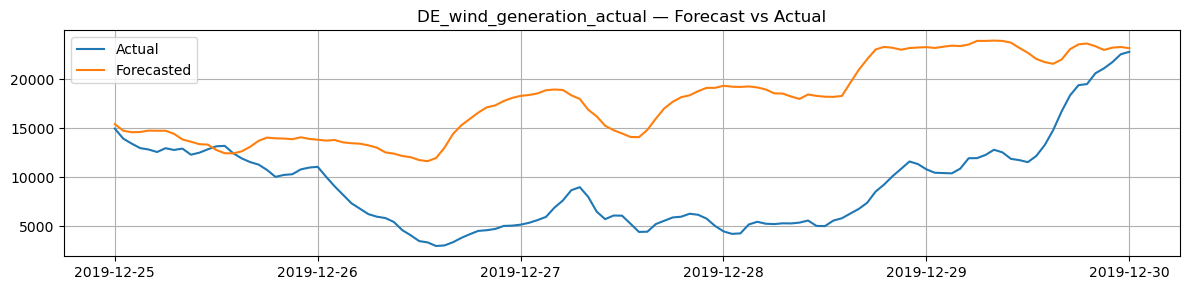

DE_load_actual_entsoe_transparency → MAE: 3513.17, RMSE: 4570.07


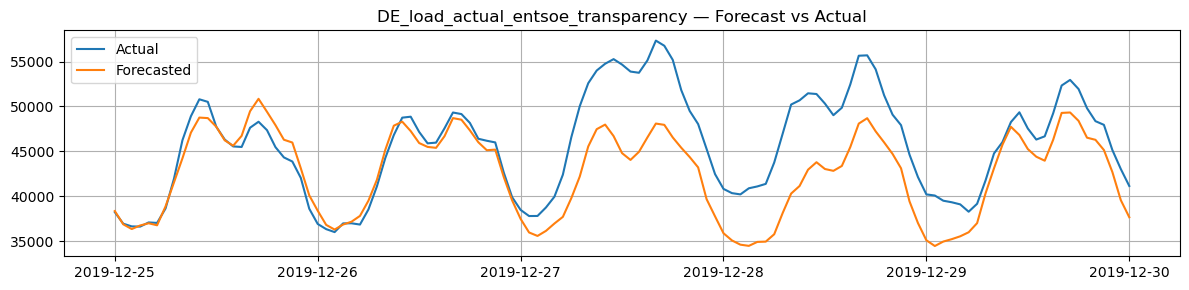

Gas_Price → MAE: 0.05, RMSE: 0.06


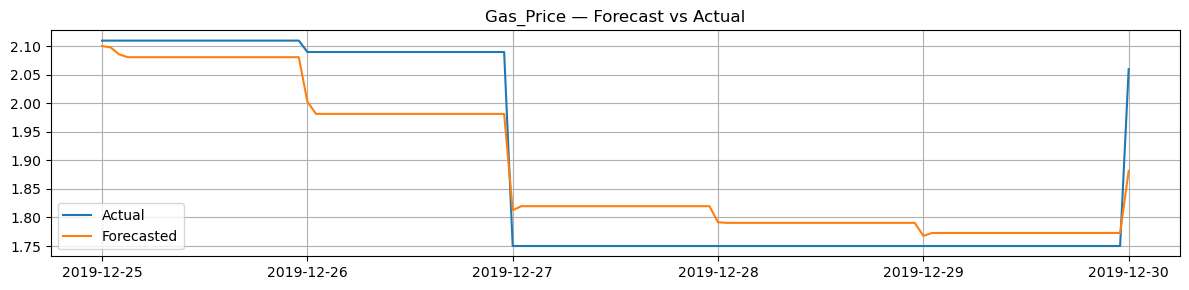

Oil_Price → MAE: 0.20, RMSE: 0.25


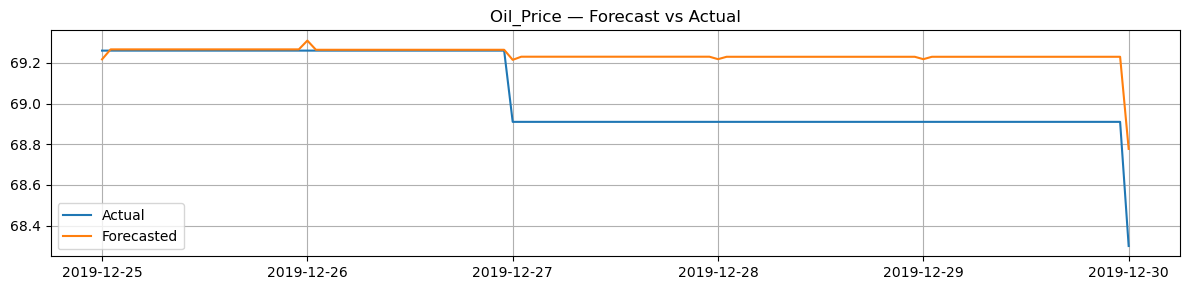

DE_radiation_direct_horizontal → MAE: 332.61, RMSE: 461.44


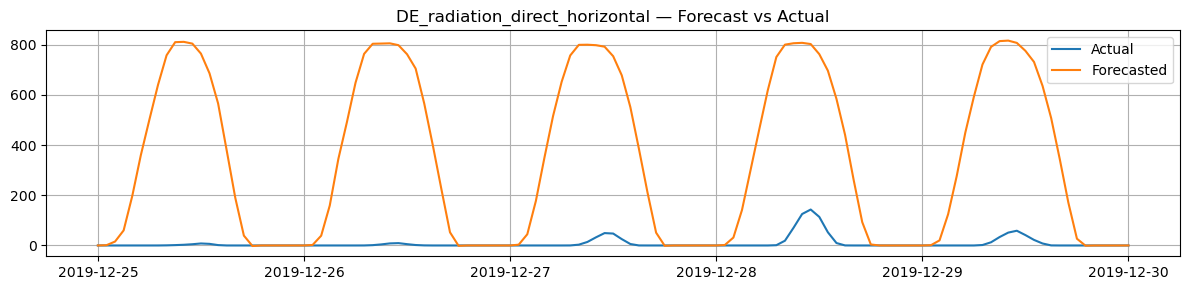

DE_radiation_diffuse_horizontal → MAE: 4.75, RMSE: 8.06


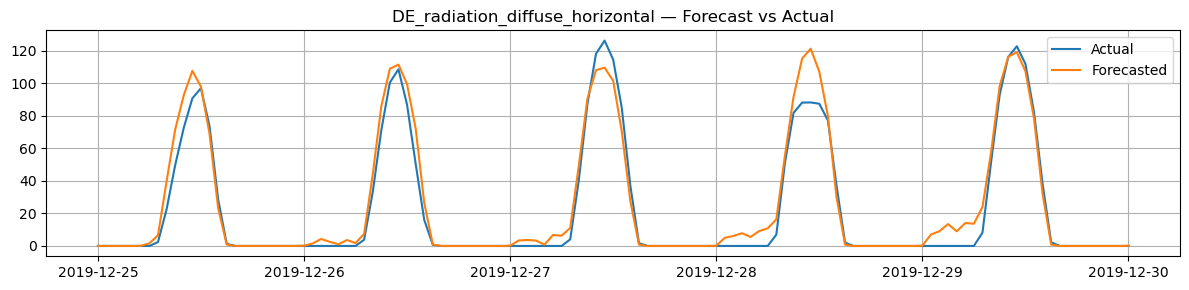

DE_temperature → MAE: 3.85, RMSE: 4.38


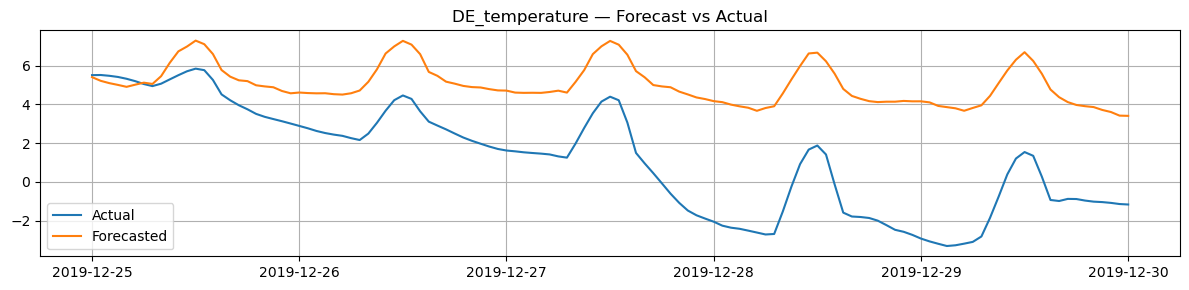

solar_load_ratio → MAE: 0.06, RMSE: 0.13


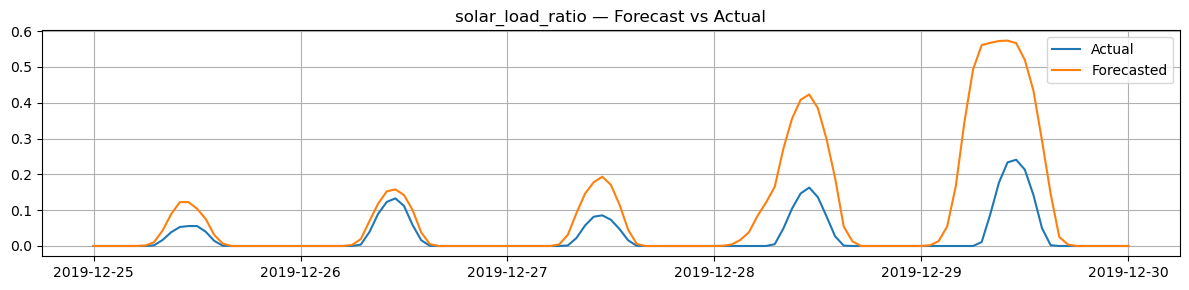

wind_load_ratio → MAE: 0.11, RMSE: 0.12


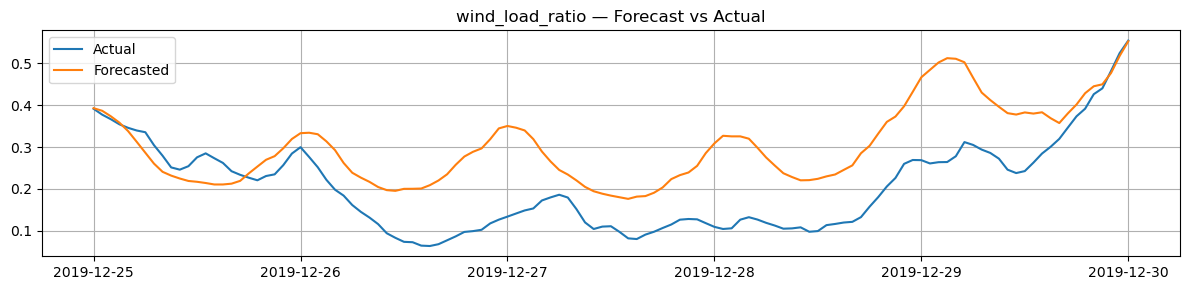

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📥 Load actual data again (full range)
df_actual = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df_actual.set_index('utc_timestamp', inplace=True)
df_actual = df_actual.sort_index()

# 📆 Evaluation window
eval_start = pd.Timestamp('2019-12-25 00:00:00')
eval_end = pd.Timestamp('2019-12-31 23:00:00')

# 📤 Forecasted data
df_forecast = combined.copy()
df_forecast = df_forecast.loc[eval_start:eval_end]

# 📥 Actual values for matching columns only
columns_to_evaluate = [col for col in df_forecast.columns if col in df_actual.columns]
# For the ratios, we compute them directly from actuals
df_actual['solar_load_ratio'] = df_actual['DE_solar_generation_actual'] / df_actual['DE_load_actual_entsoe_transparency']
df_actual['wind_load_ratio'] = df_actual['DE_wind_generation_actual'] / df_actual['DE_load_actual_entsoe_transparency']

# 🔁 Add ratios to columns to evaluate
columns_to_evaluate += ['solar_load_ratio', 'wind_load_ratio']

print("📊 Feature Forecast Evaluation for Dec 25–31, 2019\n")

for col in columns_to_evaluate:
    if col not in df_forecast.columns or col not in df_actual.columns:
        print(f"⚠️ Skipping {col}: Not found in both actual and forecasted data")
        continue

    # Align actual and predicted on common datetime index
    valid_idx = df_forecast.index.intersection(df_actual.index)
    y_true = df_actual.loc[valid_idx, col]
    y_pred = df_forecast.loc[valid_idx, col]


    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5

    print(f"{col} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 3))
    plt.plot(y_true.index, y_true, label='Actual')
    plt.plot(y_pred.index, y_pred, label='Forecasted')
    plt.title(f"{col} — Forecast vs Actual")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
